In [1]:
import numpy as np
import torch
import sys
from utils import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def free_gpu_cache():
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)
#free_gpu_cache()

In [3]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [4]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)

# 画ROC

In [5]:
# path_LFI = './checkpoint1300008/30/'
# path_Fea_G = './checkpoint1300016/60/'
# path_Gaussian = './Gaussian/checkpoint1299999/800/'
# path_Scheffe = './Scheffe/checkpoint1299999/50/'
# path_dict_roc = {
#     'MMD-L': path_LFI,
#     #'MMD-G': path_Fea_G,
#     'MMD-O': path_Gaussian,
#     'Scheffe': path_Scheffe,
# }

100%|██████████| 3/3 [00:21<00:00,  7.13s/it]


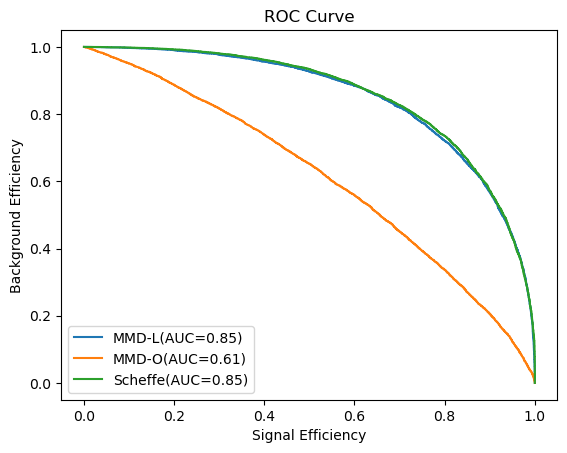

ROC saved at ROC_curve.pdf


In [6]:
# for key in tqdm(path_dict_roc):
#     path = path_dict_roc[key]
#     if key == 'Scheffe':
#         model = Classifier(300, 6).to(device)
#     if key == 'MMD-O':
#         model = DN(300, 100).to(device)
#     if key == 'MMD-L':
#         model = DN(300, 100).to(device)
#     another_model = another_DN().to(device)
#     model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
#     gc.collect()
#     torch.cuda.empty_cache()
#     with torch.no_grad():
#         M = 10000
#         Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
#                     dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
#         Z = MatConvert(Z, device, dtype)
#         PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
#                     model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, M=10000)
#         PQhat = PQhat.cpu().detach().numpy()
#         auc, x, y = get_auc_and_x_and_y(PQhat)
#         label = key+'(AUC={:.2f})'.format(auc.item())
#         plt.plot(x, y, label=label)
#         p = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
#         print('p-value = %.3f'%p)
#         clear_output(wait=True)
# plt.legend()
# plt.xlabel('Signal Efficiency')
# plt.ylabel('Background Efficiency')
# plt.title('ROC Curve')
# plt.savefig('ROC_curve.pdf', dpi = 3000)
# plt.show()
# print('ROC saved at ROC_curve.pdf')


In [7]:
gc.collect()
torch.cuda.empty_cache()

# 画 p value - n

In [34]:
def get_ps(path_dict, method, fix_thres = 0.5):
    print('-------- start get_ps --------')
    ps = np.zeros(len(path_dict))
    ps_thres = np.zeros(len(path_dict))
    ps_thres_5 = np.zeros(len(path_dict))
    for i, key in enumerate(path_dict):
        path = path_dict[key]
        if method == 'Scheffe':
            model = Classifier(300, 6).cuda()
        if method == 'MMD-O':
            model = DN(300, 100).cuda()
        if method == 'MMD-L':
            model = DN(300, 100).cuda()
        if method == 'MMD-G':
            model = DN(300, 100).cuda()
        another_model = another_DN(300, 100).cuda()
        model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
        gc.collect()
        torch.cuda.empty_cache()
        ##### 直接的pval
        M = 10000
        Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
        Z = MatConvert(Z, device, dtype)
        PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = 1000)
        PQhat = PQhat.cpu().detach().numpy()
        p = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)\
        ps[i] = p
        ##### 学thres
        M = 10000
        Z = np.concatenate((dataset_P[np.random.choice(key, M, replace=False)],
                    dataset_Q[np.random.choice(key, M, replace=False)]), axis=0)
        Z = MatConvert(Z, device, dtype)
        PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = 1000)
        PQhat = PQhat.cpu().detach().numpy()
        thres = get_thres(PQhat)
        ##### 用这个thres
        Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
        Z = MatConvert(Z, device, dtype)
        PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = 1000)
        PQhat = PQhat.cpu().detach().numpy()
        p_thres = get_thres_pval(PQhat, thres)
        ps_thres[i] = p_thres
        ##### 用0.5
        p_thres_5 = get_thres_pval(PQhat, fix_thres)
        ps_thres_5[i] = p_thres_5
        #####
        print('n = %d'%key, ', p-value = %.3f'%p, 'p-value_thres = %.3f'%p_thres, 'thres = %.3f'%thres, 'p-value_thres_5 = %.3f'%p_thres_5)
        print('------------------------------')

    return ps, ps_thres, ps_thres_5

ns = np.array([1300000, 1000000, 700000, 400000, 100000, 50000])
ps_L = ps_G = ps_O = ps_S = np.zeros(ns.shape[0])

SyntaxError: invalid syntax (1220165271.py, line 30)

In [35]:
# MMD-L
path_dict = {    
    1300000: './checkpoint1300101/25/',
    1000000: './checkpoint1000101/25/',
    700000: './checkpoint700001/40/',
    400000: './checkpoint400000/60/',
    100000: './checkpoint100000/60/',
    50000: './checkpoint50000/50/',
}
ps_L, ps_L_thres, _ = get_ps(path_dict, 'MMD-L')
ps_L, ps_L_thres


-------- start get_ps --------
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)


In [ ]:
# MMD-G
path_dict = {
    1300000: './Fea_Gau/checkpoint1300000/35/',
    1000000: './Fea_Gau/checkpoint1000000/35/',
    700000: './Fea_Gau/checkpoint700000/30/',
    400000: './Fea_Gau/checkpoint400000/30/',
    100000: './Fea_Gau/checkpoint100000/30/',
    50000: './Fea_Gau/checkpoint50000/30/',
}
ps_G, ps_G_thres, _ = get_ps(path_dict, 'MMD-G')
ps_G, ps_G_thres


-------- start get_ps --------
Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
thres= 0.23829894 ,max= 0.30419642 ,min= -0.013991094
epsilonOPT = Fea_Gau
It is Fea_Gau
test max: 0.27309096 test min: -0.013158908
a: 0.13 , b: 0.9958 , E: 17.19999999999998
test max: 0.27309096 test min: -0.013158908
a: 0.0 , b: 1.0 , E: 0.0
n = 1300000 , p-value = 4.783 p-value_thres = 4.642 thres = 0.238 p-value_thres_5 = inf
------------------------------
Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
thres= 0.20336366 ,max= 0.27532244 ,min= -0.016888198
epsilonOPT = Fea_Gau
It is Fea_Gau
test max: 0.28260994 test min: -0.017697599
a: 0.4208 , b: 0.9528 , E: 89.28000000000002
test max: 0.28260994 test min: -0.017697599
a: 0.0 , b: 1.0 , E: 0.0
n = 1000000 , p-value = 4.486 p-value_thres = 4.885 thres = 0.203 p-value_thres_5 = inf
------------------------------
Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
thres= 0.22285923 ,max= 0.2856053 ,min= -0.031822123
epsilonOPT = Fea_Gau
It is Fea_Gau
test max: 0.28613892 t

(array([4.78250203, 4.48604182, 4.32965033, 4.37532543, 3.67606017,
        3.31272771]),
 array([4.64243037, 4.88500897, 4.36922098, 4.33895586, 3.24837716,
        3.08893067]))

In [ ]:
# MMD-O
path_dict = {
    1300000: './Gaussian/checkpoint1299999/800/',
    1000000: './Gaussian/checkpoint1000000/430/',
    700000: './Gaussian/checkpoint700000/20/',
    400000: './Gaussian/checkpoint400000/10/',
    100000: './Gaussian/checkpoint100000/20/',
    50000: './Gaussian/checkpoint50000/40/',
}
ps_O, ps_O_thres, _ = get_ps(path_dict, 'MMD-O')
ps_O, ps_O_thres

-------- start get_ps --------
Gaussian
epsilonOPT = Gaussian
It is Gaussian
thres= 0.0016984871 ,max= 0.012570002 ,min= -0.0057090884
epsilonOPT = Gaussian
It is Gaussian
test max: 0.0145817725 test min: -0.007369478
a: 0.7186 , b: 0.4026 , E: 669.26
test max: 0.0145817725 test min: -0.007369478
a: 0.0 , b: 1.0 , E: 0.0
n = 1300000 , p-value = 1.122 p-value_thres = 0.759 thres = 0.002 p-value_thres_5 = inf
------------------------------
Gaussian
epsilonOPT = Gaussian
It is Gaussian
thres= 2.4113999e-05 ,max= 0.003828496 ,min= -0.0026634915
epsilonOPT = Gaussian
It is Gaussian
test max: 0.0029827233 test min: -0.0028166124
a: 0.6798 , b: 0.448 , E: 619.98
test max: 0.0029827233 test min: -0.0028166124
a: 0.0 , b: 1.0 , E: 0.0
n = 1000000 , p-value = 0.768 p-value_thres = 0.745 thres = 0.000 p-value_thres_5 = inf
------------------------------
Gaussian
epsilonOPT = Gaussian
It is Gaussian
thres= 0.0027810526 ,max= 0.0129914135 ,min= -0.009718197
epsilonOPT = Gaussian
It is Gaussian
test

(array([1.12223373, 0.76806442, 0.93039049, 1.01106563, 0.77515962,
        0.89167475]),
 array([0.759026  , 0.74527025, 0.77918904, 0.6924966 , 0.79404331,
        0.8019496 ]))

In [ ]:
# Scheffe
path_dict = {
    1300000: './Scheffe/checkpoint1299999/50/',
    1000000: './Scheffe/checkpoint1000000/30/',
    700000: './Scheffe/checkpoint700000/60/',
    400000: './Scheffe/checkpoint400000/60/',
    100000: './Scheffe/checkpoint100000/60/',
    50000: './Scheffe/checkpoint50000/60/',
}
ps_S, ps_S_thres, ps_S_thres_5 = get_ps(path_dict, 'Scheffe', fix_thres = 0.5)
ps_S, ps_S_thres, ps_S_thres_5

-------- start get_ps --------
Scheffe
epsilonOPT = Scheffe
It is Scheffe
thres= 0.9202932 ,max= 0.9995968 ,min= 3.3975044e-05
epsilonOPT = Scheffe
It is Scheffe
test max: 0.9994295 test min: 1.7810693e-05
a: 0.2217 , b: 0.9908 , E: 31.369999999999987
test max: 0.9994295 test min: 1.7810693e-05
a: 0.7866 , b: 0.7596 , E: 319.05999999999995
n = 1300000 , p-value = 4.663 p-value_thres = 5.445 thres = 0.920 p-value_thres_5 = 3.807
------------------------------
Scheffe
epsilonOPT = Scheffe
It is Scheffe
thres= 0.91047394 ,max= 0.99779534 ,min= 0.00013539084
epsilonOPT = Scheffe
It is Scheffe
test max: 0.996971 test min: 3.3109456e-05
a: 0.2009 , b: 0.9891 , E: 30.99000000000002
test max: 0.996971 test min: 3.3109456e-05
a: 0.7698 , b: 0.7555 , E: 321.4800000000001
n = 1000000 , p-value = 4.483 p-value_thres = 4.540 thres = 0.910 p-value_thres_5 = 3.618
------------------------------
Scheffe
epsilonOPT = Scheffe
It is Scheffe
thres= 0.91138244 ,max= 0.9995004 ,min= 3.9333994e-05
epsilonOPT

(array([4.66276849, 4.48323071, 4.39385695, 4.18788575, 3.43424173,
        3.07843071]),
 array([5.44479119, 4.53957636, 4.73141251, 4.59781289, 3.31876076,
        2.78277978]),
 array([3.8074026 , 3.61845391, 3.46145678, 3.38954553, 2.7915326 ,
        2.45945536]))

In [30]:
cc = (1/11*np.sqrt(1100)) / (1/10.5*np.sqrt(1050))
cc

0.9770084209183946

p-n saved at p_n_curve.pdf


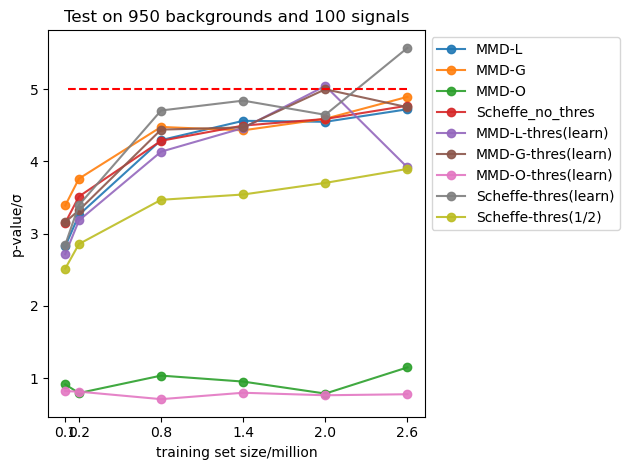

In [32]:
# for ps in [ps_L, ps_G, ps_O, ps_S]:
#     ps = ps /(1/11*np.sqrt(1100)) * (1/10.5*np.sqrt(1050))
ns = np.array([1300000, 1000000, 700000, 400000, 100000, 50000])
# 直接求和
plt.plot(ns, ps_L, label='MMD-L', marker='o', alpha=0.9)
plt.plot(ns, ps_G, label='MMD-G', marker='o', alpha=0.9)
plt.plot(ns, ps_O, label='MMD-O', marker='o', alpha=0.9)
plt.plot(ns, ps_S, label='Scheffe_no_thres', marker='o', alpha=0.9)
# 加上threshold
plt.plot(ns, ps_L_thres, label='MMD-L-thres(learn)', marker='o', alpha=0.9)
plt.plot(ns, ps_G_thres, label='MMD-G-thres(learn)', marker='o', alpha=0.9)
plt.plot(ns, ps_O_thres, label='MMD-O-thres(learn)', marker='o', alpha=0.9)
plt.plot(ns, ps_S_thres, label='Scheffe-thres(learn)', marker='o', alpha=0.9)
plt.plot(ns, ps_S_thres_5, label='Scheffe-thres(1/2)', marker='o', alpha=0.9)


plt.legend(bbox_to_anchor =(1, 1))
plt.xlabel('training set size/million')
plt.xticks(ns, ns*2/10**6)
plt.ylabel('p-value/σ')
plt.title('Test on 950 backgrounds and 100 signals')
plt.tight_layout()

plt.yticks([cc, 2*cc, 3*cc, 4*cc, 5*cc], [1, 2, 3, 4 ,5])
plt.plot(ns, 5*cc*np.ones(ns.shape[0]), 'r--')

plt.savefig('p_n_curve.pdf')
plt.savefig('p_n_curve.png')
print('p-n saved at p_n_curve.pdf')
plt.show()



# 画training of LFI

In [ ]:
# gc.collect()
# torch.cuda.empty_cache()
# model = DN(300, 100).to(device)
# another_model = another_DN(300).to(device)

# epoch_list = np.arange(0,176,10)

# p_epoch = np.zeros(epoch_list.shape[0])
# p_thres_epoch = np.zeros(epoch_list.shape[0])
# pat = './checkpoint999999/'
# J_epoch = np.load(pat+'J_star_u.npy')
# J_valid_epoch = np.load(pat+'J_validations.npy')
# mmd_epoch = np.load(pat+'mmd_val_record.npy')

# for i, epoch in tqdm(enumerate(epoch_list)):
#     path = './checkpoint999999/%d/'%epoch
#     model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
#     M = 10000
#     Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
#         dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
#     Z = MatConvert(Z, device, dtype)
#     PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
#                 model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
#                 M = 10000)
#     PQhat = PQhat.cpu().detach().numpy()
#     p_epoch[i] = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
#     p_thres_epoch[i] = get_thres_pval(PQhat)
#     clear_output(wait = True)
#     print(p_epoch[i], p_thres_epoch[i])


0it [00:00, ?it/s]

epsilonOPT = tensor([1.5049], device='cuda:0', requires_grad=True)


0it [00:01, ?it/s]


TypeError: get_thres_pval() missing 1 required positional argument: 'thres'

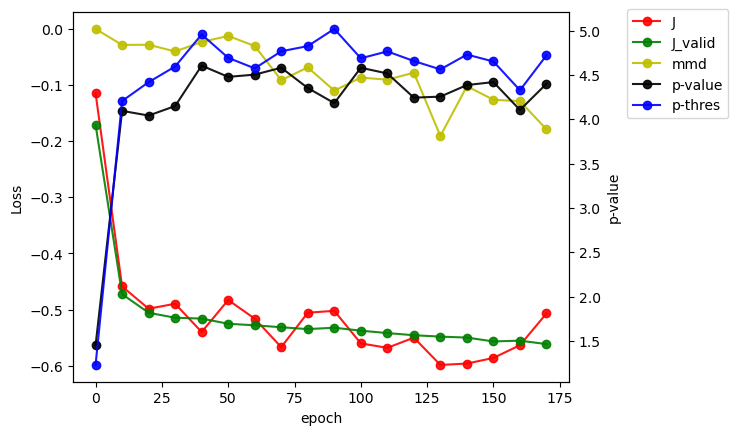

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epoch_list, J_epoch[0,epoch_list], label='J', marker='o', alpha=0.9, color='r')
ax.plot(epoch_list, J_valid_epoch[epoch_list], label='J_valid', marker='o', alpha=0.9, color='g')
ax.plot(epoch_list, mmd_epoch[0,epoch_list], label='mmd', marker='o', alpha=0.9, color='y')
ax.set_ylabel("Loss")
ax2 = ax.twinx()
ax2.set_ylabel("p-value")
ax2.plot(epoch_list, p_epoch, label='p-value', marker='o', alpha=0.9, color='k')
ax2.plot(epoch_list, p_thres_epoch, label='p-thres', marker='o', alpha=0.9, color='b')
fig.legend(loc=1, bbox_to_anchor=(1.16,0.9))
ax.set_xlabel('epoch')
plt.savefig('loss_p_epoch.pdf')

# Trade-off of m-n-pi, fix pi=0.1
#

In [ ]:
# 希望横轴是n，纵轴是m，固定3sigma，画pi的等高线
c = 11/np.sqrt(1100)
# 如果高斯近似，一个n上所有点都能算，对一个model我们需要P_mean, P_var, Q_mean
def get_gaussian_pval(n,m,pi,method=None, thres=False):
    i = np.where(ns==n)
    if method == 'MMD-L':
        return ps_L[i]*c*pi*np.sqrt(m)
    elif method == 'MMD-G':
        return ps_G[i]*c*pi*np.sqrt(m)
    elif method == 'MMD-O':
        return ps_O[i]*c*pi*np.sqrt(m)
    elif method == 'Scheffe':
        return ps_S[i]*c*pi*np.sqrt(m)
# MMD-L
path_dict_more = {    
    1600000: './checkpoint1600101/25/',
    1300000: './checkpoint1300101/25/',
    1000000: './checkpoint1000101/25/',
    700000: './checkpoint700001/40/',
    400000: './checkpoint400000/60/',
    100000: './checkpoint100000/60/',
    50000: './checkpoint50000/50/',
    10000: './checkpoint10000/170/',
    6000: './checkpoint6000/330/',
}
ps_L_more, ps_L_thres_more = get_ps(path_dict_more, 'MMD-L')

-------- start get_ps --------
epsilonOPT = tensor([-1.3849], device='cuda:0', requires_grad=True)
best thres p-val is (overfit) 5.306779726741736
epsilonOPT = tensor([-1.3849], device='cuda:0', requires_grad=True)
n = 1600000 , p-value = 4.727 p-value_thres = 0.000
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
best thres p-val is (overfit) 5.084561057504263
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
n = 1300000 , p-value = 4.552 p-value_thres = 0.000
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
best thres p-val is (overfit) 4.981980956779515
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
n = 1000000 , p-value = 4.407 p-value_thres = 0.000
epsilonOPT = tensor([-1.3838], device='cuda:0', requires_grad=True)
best thres p-val is (overfit) 4.701076001116636
epsilonOPT = tensor([-1.3838], device='cuda:0', requires_grad=True)
n = 700000 , p-value = 4.538 p-value_thres = 0.000
epsilonOPT = tensor([-2.52

In [ ]:
ns = np.array(list(path_dict.keys()))
ms = np.arange(100,1000,100)
Znm = np.zeros((len(ns), len(ms)))
# create empty df
df = pd.DataFrame(columns=['n','m','pi','p-value'])
# add data
for i,n in enumerate(ns):
    for j,m in enumerate(ms):
        pi = 5/ps_L_more[i]/c/np.sqrt(m)
        Znm[i,j] = pi
        dict = {'n':n, 
                'm':m, 
                'pi':pi.item(), 
                'p-value': 5}
        df = df.append(dict, ignore_index=True)
        clear_output(wait = True)
# fig = px.scatter_3d(df, x='n', y='m', z='pi')
# fig.show()

/tmp/ipykernel_26865/751699699.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict, ignore_index=True)


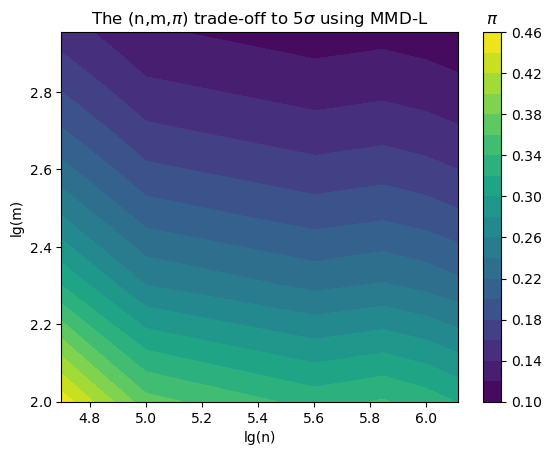

In [ ]:
plt.contourf(np.log10(ns), np.log10(ms), Znm.T, levels=20)
plt.xlabel('lg(n)')
plt.ylabel('lg(m)')
clb = plt.colorbar()
clb.ax.set_title('$\pi$')
plt.title('The (n,m,$\pi$) trade-off to 5$\sigma$ using MMD-L')
plt.savefig('n_m_pi_trade-off.pdf')
plt.savefig('n_m_pi_trade-off.png')